In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch

from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import load_mnist_data

from torchvision.utils import save_image

import numpy as np

import matplotlib.pyplot as plt
import temp

c:\Users\55366\Documents\GitHub\unsupervised_domain_adaptation\temp.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(backgrounds)


# Data

In [2]:
loader_source, mnist_eval_loader, mnist_test_loader = temp.get_mnist_loaders(batch_size=64)
loader_target, mnistm_eval_loader,mnistm_test_loader = temp.get_mnistm_loaders(batch_size=64)

# Module

## Encoder

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_nc=3):
        super(Encoder, self).__init__()

        # Initial convolution block
        model = [   nn.ReflectionPad2d(3),
                    nn.Conv2d(input_nc, 64, 7),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        model += [nn.Conv2d(64, 128, 3, stride=2, padding=1),
                  nn.InstanceNorm2d(128),
                  nn.ReLU(inplace=True)]
        model += [nn.Conv2d(128, 256, 3, stride=2, padding=1),
                  nn.InstanceNorm2d(256),
                  nn.ReLU(inplace=True)]

        model += [nn.Conv2d(256, 256, 3, stride=2, padding=1),
                  nn.InstanceNorm2d(256),
                  nn.ReLU(inplace=True)]

        model += [nn.Conv2d(256, 512, 3, stride=2, padding=1),
                  nn.InstanceNorm2d(512),
                  nn.ReLU(inplace=True)]


        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


## Decoder

In [4]:
class Decoder(nn.Module):
    def __init__(self, input_nc=512, output_nc=3):
        super(Decoder, self).__init__()

        model = [nn.ConvTranspose2d(input_nc, 256, 3, stride=2, padding=1, output_padding=1),
                  nn.InstanceNorm2d(256),
                  nn.ReLU(inplace=True)]
        model += [nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=0),
                  nn.InstanceNorm2d(128),
                  nn.ReLU(inplace=True)]
        model += [nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
                  nn.InstanceNorm2d(64),
                  nn.ReLU(inplace=True)]
        model += [nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),
                  nn.InstanceNorm2d(64),
                  nn.ReLU(inplace=True)]

        # Output layer
        model += [  nn.ReflectionPad2d(3),
                    nn.Conv2d(64, output_nc, 7),
                    nn.InstanceNorm2d(3),
                    nn.Tanh() ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

## Identity Generator

In [5]:
class Identity_Generator(nn.Module):
    def __init__(self, encoder, decoder):
        super(Identity_Generator, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, A, B):
        latentA = self.encoder(A)
        latentB = self.encoder(B)

        reconstructedA = self.decoder(latentA)
        reconstructedB = self.decoder(latentB)
        return reconstructedA, reconstructedB

## Perceptual

In [6]:
class Perceptual(nn.Module):
    def __init__(self, encoder, decoder, generator):
        super(Perceptual, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.generator = generator

    def forward(self, A, B):

        reconstructedA, reconstructedB = self.generator(A, B)

        latentA = self.encoder(A)
        latentB = self.encoder(B)

        latentA.detach()
        latentB.detach()

        style = latentA[:, 0:256, : , :]
        content = latentB[:, 256:512, :, :]

        mixed_latent = torch.cat([style, content], dim=1)
        mixed_image = self.decoder(mixed_latent)

        return mixed_image, reconstructedA, reconstructedB

## Discriminator

In [25]:
class Discriminator(nn.Module):
    def __init__(self, input_nc = 3):
        super(Discriminator, self).__init__()

        model = [   nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(64, 128, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(128), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(128, 256, 4, stride=2, padding=1),
                    nn.InstanceNorm2d(256), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [  nn.Conv2d(256, 512, 4, padding=1),
                    nn.InstanceNorm2d(512), 
                    nn.LeakyReLU(0.2, inplace=True) ]

        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x =  self.model(x)
        return x
        # return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

## Model test

In [26]:
test_tensor_source = torch.rand(20, 3, 28, 28)
test_tensor_target = torch.rand(20, 3, 28, 28)

encoder = Encoder()
decoder = Decoder()
generator = Identity_Generator(encoder, decoder)
perceptual = Perceptual(encoder, decoder, generator)
discriminator = Discriminator()

In [9]:
output = encoder(test_tensor_source)
print(output.size())

torch.Size([20, 512, 2, 2])


In [10]:
output = decoder(output)
print(output.size())

torch.Size([20, 3, 28, 28])


In [13]:
output_a, output_b = generator(test_tensor_source, test_tensor_target)
print(output_a.size())
print(output_b.size())

torch.Size([20, 3, 28, 28])
torch.Size([20, 3, 28, 28])


In [27]:
mix, output_a, output_b = perceptual(test_tensor_source, test_tensor_target)

print(mix.size())
print(output_a.size())
print(output_b.size())

torch.Size([20, 3, 28, 28])
torch.Size([20, 3, 28, 28])
torch.Size([20, 3, 28, 28])


In [29]:
output = Discriminator(test_tensor_source)
print(output.size())

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

# Loss

In [ ]:
def tv_loss(img, tv_weight=5e-2):
    w_variance = torch.sum(torch.pow(img[:,:,:,:-1] - img[:,:,:,1:], 2))
    h_variance = torch.sum(torch.pow(img[:,:,:-1,:] - img[:,:,1:,:], 2))
    loss = tv_weight * (h_variance + w_variance)
    return loss

def total_variation_loss(img, weight=5e-2):
    bs_img, c_img, h_img, w_img = img.size()
    tv_h = torch.pow(img[:, :, 1:, :] - img[:, :, :-1, :], 2).sum()
    tv_w = torch.pow(img[:, :, :, 1:] - img[:, :, :, :-1], 2).sum()
    return weight * (tv_h + tv_w) / (bs_img * c_img * h_img * w_img)

# Training

## Training Method

In [ ]:
def train_with_autoencoder(source, target, preceptual, criterion, criterion_construct, optimizer, use_cuda, epoch):
    data_target_iter = iter(target)
    total = 0

    for batch_idx, (source_inputs, source_label) in enumerate(source):
        batch_size = source_inputs.size(0)
        total += batch_size

        target_inputs, target_label = data_target_iter.next()

        optimizer.zero_grad()

        if use_cuda: 
            source_inputs, target_inputs = source_inputs.cuda(), source_label.cuda()

        mixed_image, reconstruct_source, reconstruct_target = preceptual(source_inputs, target_inputs)

        loss_ss = criterion_construct(source_inputs, reconstruct_source)
        loss_tt = criterion_construct(target_inputs, reconstruct_target)

        TV_loss = total_variation_loss(mixed_image)


        total_loss = loss_ss + loss_tt + TV_loss

        





## Model hypermeter

In [16]:
encoder = Encoder(input_nc = 3)
decoder = Decoder()
generator = Identity_Generator(encoder, decoder)
perceptual = Perceptual(encoder, decoder, generator)

In [17]:
learning_rate = 0.01
beta = (0.5, 0.999)

criterion_construct = torch.nn.MSELoss()

optimizer_gen = torch.optim.Adam(perceptual.parameters(),lr=learning_rate, betas=beta)

In [18]:
if (torch.cuda.is_available()):
    torch.cuda.manual_seed_all(42)
    cudnn.benchmark = True
    criterion_construct = criterion_construct.cuda()

    encoder.cuda()
    decoder.cuda()
    generator.cuda()
    perceptual.cuda()

## Init the network

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

In [19]:
encoder.apply(weights_init_normal)
decoder.apply(weights_init_normal)
generator.apply(weights_init_normal)

Identity_Generator(
  (encoder): Encoder(
    (model): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
      (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): ReLU(inplace=True)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (11): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (12): ReLU(inplace=True)
      (13): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      

## Training method

In [46]:
def train(source, target, epoch, cuda = True):
     data_target_iter = iter(target)
     total = 0
     s_loss = 100000
     t_s_loss = 100000
     t_t_loss = 100000
     loss_min = 100000

     image_ss = []
     image_ts = []
     image_s = []
     image_t = []

     pre_source = None
     pre_target = None

     for batch_idx, (source_inputs, _) in enumerate(source):
          batch_size = source_inputs.size(0)
          total += batch_size
          optimizer_gen.zero_grad()

          target_inputs, _ = data_target_iter.next()

          if (pre_source == None and pre_target == None):
               pre_source = source_inputs
               pre_target = target_inputs

          source_inputs, target_inputs = Variable(source_inputs), Variable(target_inputs)
          
          if (cuda):
               source_inputs, target_inputs = source_inputs.cuda(), target_inputs.cuda()
               pre_source, pre_target = pre_source.cuda(), pre_target.cuda()

          reconstruct_source, reconstruct_target = generator(source_inputs, target_inputs)

          if(reconstruct_source.size()[0] != pre_target.size()[0]):
               break

          loss_construct_ss = criterion_construct(reconstruct_source, source_inputs)
          loss_construct_st = criterion_construct(reconstruct_source, pre_target)
          loss_construct_ts = criterion_construct(reconstruct_target, pre_source)
          loss_construct_tt = criterion_construct(reconstruct_target, target_inputs)


          total_loss = loss_construct_ss + loss_construct_st + loss_construct_ts + loss_construct_tt
          total_loss.backward()
          optimizer_gen.step()
          
          pre_source = reconstruct_source.detach()
          pre_target = reconstruct_target.detach()

          

          if (total_loss < loss_min):
               loss_min = total_loss

               image_ss = reconstruct_source.data.cpu().detach().numpy()
               image_ts = reconstruct_target.data.cpu().detach().numpy()
               image_t = target_inputs.data.cpu().detach().numpy()
               image_s = source_inputs.data.cpu().detach().numpy()



     return loss_min, image_ss, image_ts, image_t, image_s


epoch: 0, error: 1.072637
epoch: 1, error: 1.029437
epoch: 2, error: 0.958961
epoch: 3, error: 0.943205
epoch: 4, error: 0.943972
epoch: 5, error: 0.913843
epoch: 6, error: 0.921472
epoch: 7, error: 0.922159
epoch: 8, error: 0.907962
epoch: 9, error: 0.902261
epoch: 10, error: 0.899697
epoch: 11, error: 0.890988
epoch: 12, error: 0.889104
epoch: 13, error: 0.888852
epoch: 14, error: 0.884682
epoch: 15, error: 0.880089
epoch: 16, error: 0.885907
epoch: 17, error: 0.882289
epoch: 18, error: 0.870190
epoch: 19, error: 0.887417
epoch: 20, error: 0.869514
epoch: 21, error: 0.876296
epoch: 22, error: 0.871703
epoch: 23, error: 0.875266
epoch: 24, error: 0.874725
epoch: 25, error: 0.872106
epoch: 26, error: 0.877949
epoch: 27, error: 0.873812
epoch: 28, error: 0.874903
epoch: 29, error: 0.877035
epoch: 30, error: 0.877673
epoch: 31, error: 0.873075
epoch: 32, error: 0.870052
epoch: 33, error: 0.874784
epoch: 34, error: 0.865042
epoch: 35, error: 0.872920
epoch: 36, error: 0.856316
epoch: 37, 

C:\Users\55366\AppData\Local\Temp\ipykernel_14344\3978338898.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(nrows=2, ncols = 2, figsize=(3, 5))


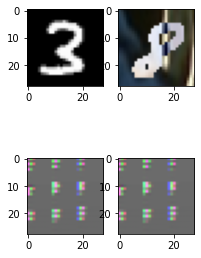

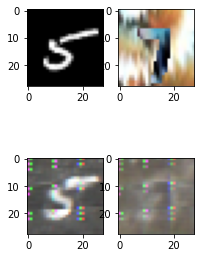

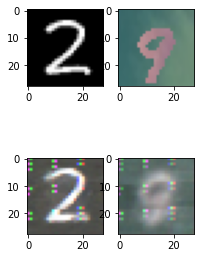

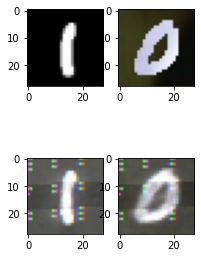

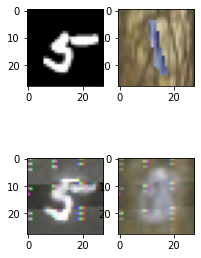

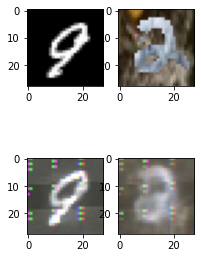

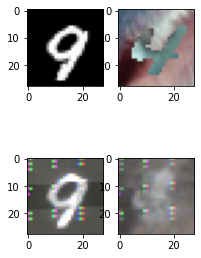

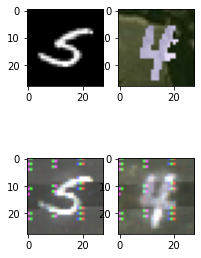

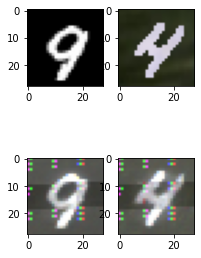

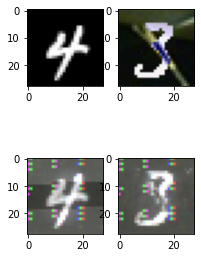

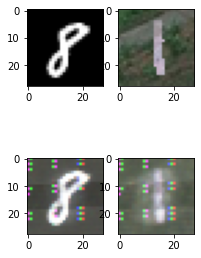

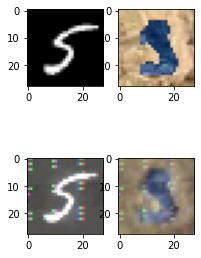

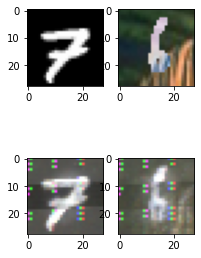

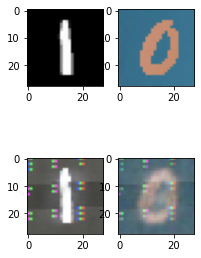

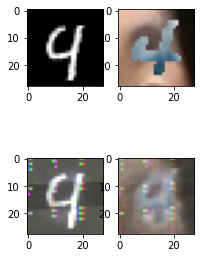

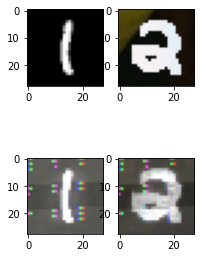

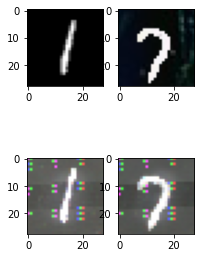

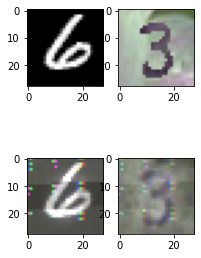

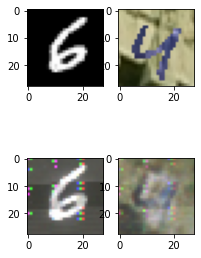

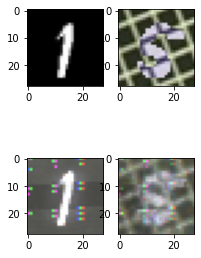

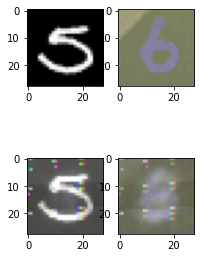

In [47]:
for i in range(201):
    err, image_ss, image_ts, image_t, image_s = train(loader_source, loader_target, i)
    print("epoch: %d, error: %f" % (i, err))
    index = 0

    if(i % 10 == 0):
        fig, axs = plt.subplots(nrows=2, ncols = 2, figsize=(3, 5))
        img = image_s[index].reshape(28,28,3)
        img = (img + 1) * 0.5

        img2 = image_t[index].reshape(28,28,3)
        img2 = (img2 + 1) * 0.5

        img3 = image_ss[index].reshape(28,28,3)
        img3 = (img3 + 1) * 0.5

        img4 = image_ts[index].reshape(28,28,3)
        img4 = (img4 + 1) * 0.5

        axs[0, 0].imshow(img)
        axs[0 ,1].imshow(img2)
        axs[1 ,0].imshow(img3)
        axs[1 ,1].imshow(img4)

        fig.savefig('./reconstruct/%d_img.png' % i)

